In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType

from torch.nn import Transformer
from torch.nn import Transformer_1dcnn





from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
mm_scaler = MinMaxScaler()

class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 20:21].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()

        self.src_c = df.iloc[x_size:, 6:7].values #I
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()


        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])

        
        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

        print(src_v.shape)
        self.src_v = src_v
        print(src_c.shape)
        self.src_c = src_c
        self.trg = trg

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

In [3]:
train_dataset_1 = StrideDataset("DST_80.csv", 50, 20, 1919, stride=5)

(2114, 50, 1)
(2114, 50, 1)


In [4]:
flag = np.zeros(19)
flag_soc = flag + 0.5
flag

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [5]:
class StrideDataset_e(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 20:21].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()
        self.soc = np.concatenate((flag_soc, self.soc))
        plt.plot(self.soc)

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()
        self.src_v = np.concatenate((self.src_v, flag))
        

        self.src_c = df.iloc[x_size:, 6:7].values #I
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()
        self.src_c = np.concatenate((self.src_c, flag))


        self.length = len(df) - x_size + 19

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])


        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
        print(src_v.shape)
        
        # trg = np.concatenate((flag,trg), 1)
        # print(trg.shape)

        self.src_v = src_v
        self.src_c = src_c
        self.trg = trg
        
        

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

(2209, 50, 1)


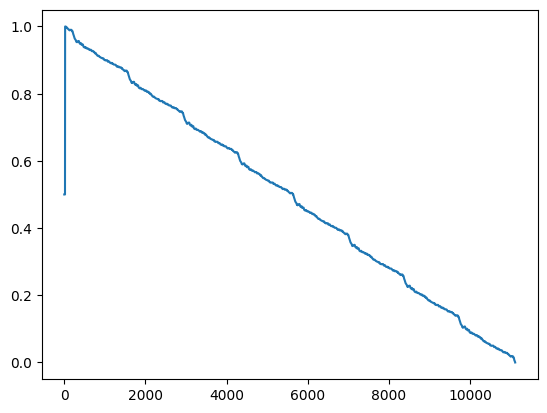

In [6]:
train_dataset_1 = StrideDataset_e("FUDS_80.csv", 50, 20, 2586, stride=5)


In [7]:
# class StrideDataset_2(Dataset):
#     def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
#         df = pd.read_csv(file_path)
        
#         self.data = df.iloc[x_size:, 13:14].values #SoC
#         self.data = self.data.squeeze()

#         self.length = len(df) - x_size

#         num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
#         src = np.zeros([enc_seq_len, num_samples])
#         trg = np.zeros([target_seq_len, num_samples])


#         for i in np.arange(num_samples):
#             start_x = stride*i
#             end_x = start_x + enc_seq_len
#             src[:,i] = self.data[start_x:end_x]

#             start_y = stride*i + enc_seq_len
#             end_y = start_y + target_seq_len
#             trg[:,i] = self.data[start_y:end_y]

#         src = src.reshape(src.shape[0], src.shape[1], 1).transpose((1,0,2))
#         trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
#         self.src = src
#         self.trg = trg

#         self.len = len(src)

#     def __getitem__(self, i):
#         return self.src[i], self.trg[i, :-1], self.trg[i, 1:]
    
#     def __len__(self):
#         return self.len

In [8]:
flag_y = np.zeros(51)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 20:21].values
        
        self.length = len(df) - x_size

    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [10]:
dataset_d = CustomDataset("DST_80.csv", 1919)


In [11]:
train_dataset_1 = StrideDataset("DST_80.csv", 50, 20, 1919, stride=5)
train_dataset_2 = StrideDataset("US06_80.csv", 50, 20, 1207, stride=5)
# train_dataset_1 = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=5)
# train_dataset_2 = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=5)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])
# train_dataset = train_dataset_2


train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
# dataset_d = CustomDataset("DST_80.csv", 1919)

(2114, 50, 1)
(2114, 50, 1)
(2125, 50, 1)
(2125, 50, 1)


In [12]:
# plt.plot(train_dataset_1)
# plt.show()
# plt.plot(train_dataset.src_v.squeeze())
# plt.show()
# plt.plot(train_dataset.trg.squeeze())
# plt.show()


In [13]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()

        # self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        
        # self.linear = nn.Linear(d_model, 1)
        # self.pos_encoder = PositionalEncoding(d_model, dropout)

        # self.encoder = nn.Linear(1, d_model)

        self.coder_in = nn.Linear(1,d_model)
        
        self.conv_in = nn.Sequential(
            nn.Conv1d(1, d_model, kernel_size=15),
            nn.Softmax(dim=1),
            nn.Linear(50-15+1, 50) #src-ker+1, src
        )
        self.coder_in2 = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, d_model)
        )
        
        self.conv_in_dec = nn.Sequential(
            nn.Conv1d(1,500,kernel_size=15),
            nn.Softmax(dim=1),
            nn.Linear(20-15, 20-1) #dec-ker, dec-1
        )
        
        
        self.conv_out = nn.Sequential(
            nn.Conv1d(500,50,kernel_size=5,stride=3),
            #nn.ReLU(),
            nn.Conv1d(50,1,kernel_size=3,stride=1),
            #nn.ReLU(),
            nn.Linear(3,30),
            #nn.ReLU(),
            nn.Linear(30,19)
        )

        self.coder_pos = PositionalEncoding(d_model, dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        
        #
        self.encoder_layer_1dcnn = nn.TransformerEncoderLayer_1dcnn(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder_1dcnn = nn.TransformerEncoder_1dcnn(self.encoder_layer_1dcnn, num_layers=nlayers)
        #


        self.con_lin = nn.Linear(d_model*2, d_model)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=nlayers) #(target, memory) // memort->인코더에서 나온 컨텍스트벡터?
        #
        self.decoder_layer_1dcnn = nn.TransformerDecoderLayer_1dcnn(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder_1dcnn = nn.TransformerDecoder_1dcnn(self.decoder_layer_1dcnn, num_layers=nlayers)
        #
        
        
        
        
        self.linear = nn.Sequential(
            nn.Linear(d_model, 1)
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.linear_in = nn.Linear(1, d_model)
        

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    #def forward(self, src, tgt, srcmask, tgtmask):
    def forward(self, src_v, src_c, tgt_s, src_mask_v, src_mask_c, tgtmask):
        # src_v = self.coder_in(src_v)
        src_v = self.coder_in2(src_v)
        # src_v = self.conv_in(src_v.transpose(2,1)).transpose(2,1)
        src_v = self.coder_pos(src_v)

        # src_c = self.coder_in(src_c)
        src_c = self.coder_in2(src_c)
        # src_c = self.conv_in(src_c.transpose(2,1)).transpose(2,1)
        src_c = self.coder_pos(src_c)

        # print(src_v.shape)
        con_v = self.transformer_encoder(src_v.transpose(0,1), src_mask_v).transpose(0,1)  #-> 그냥
        # con_v = self.transformer_encoder_1dcnn(src_v.transpose(0,1), src_mask_v) #-> 인코더 ff 1dcnn
        # print(con_v.shape)
        con_c = self.transformer_encoder(src_c.transpose(0,1), src_mask_c).transpose(0,1)
        # con_c = self.transformer_encoder_1dcnn(src_c.transpose(0,1), src_mask_c)
        
        #print(con_v.shape)
        #print(con_c.shape)
        

        con = torch.cat((con_v, con_c), dim=2)
        #print(con.shape)
        
        con = self.con_lin(con)
        #print(con.shape)
        
        
        #print(tgt_s.shape)
        tgt_s = self.coder_in(tgt_s)
        # tgt_s = self.conv_in_dec(tgt_s.transpose(2,1)).transpose(2,1)
        tgt_s = self.coder_pos(tgt_s)
        
        
        tgt = self.transformer_decoder(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        # tgt = self.transformer_decoder_1dcnn(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        # print(tgt.shape)
        tgt = self.linear(tgt) #이거중
        # tgt = self.linear2(tgt)
        # tgt = self.conv_out(tgt.transpose(2,1)).transpose(2,1)
        # print(tgt.shape)

        return tgt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [14]:
lr = 0.00003
model = TFModel(256, 8, 512, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [15]:
epoch = 4000
model.train()
progress = tqdm(range(epoch))

loss_arr = list()


for i in progress:
    batchloss = 0.0
    for (inputs_v, inputs_c, dec_inputs, outputs) in train_dataloader:
        optimizer.zero_grad()
        #print(inputs_v.shape[1])
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        #print(dec_inputs.shape[1])
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        result = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        
        #loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        loss = criterion(result, outputs.float().to(device))
        
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    
        
    loss_arr.append((batchloss.cpu().item() / len(train_dataloader)))
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))




    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
    
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

loss: 0.000020: 100%|██████████| 4000/4000 [2:14:28<00:00,  2.02s/it]  


In [16]:
import torch
import torch.nn as nn

batch_size = 3
feature_dim = 256
time_step = 16000

x = torch.rand(2206, 1, 50)

conv1d = nn.Conv1d(1, 1, kernel_size=10, stride=2)
conv1d_2 = nn.Conv1d(1,1, kernel_size=5, stride=3)
li1 = nn.Linear(3, 35)
li2 = nn.Linear(35,50)
li3 = nn.Linear(21,50)

out = conv1d(x)
print(out.shape)
# out = conv1d_2(out)
# print(out.shape)


# out = li1(out)
# out = li2(out)
out = li3(out)

print('output_size:',out.shape)

torch.Size([2206, 1, 21])
output_size: torch.Size([2206, 1, 50])


In [17]:
x = torch.rand(257, 500, 19)

conv1d = nn.Conv1d(500, 700, kernel_size=5, stride=3)
conv1d_2 = nn.Conv1d(700,700, kernel_size=3, stride=1)
li1 = nn.Linear(700,500)
li2 = nn.Linear(3,50)

out = conv1d(x)
out = conv1d_2(out)
out = li2(out)
out = li1(out.transpose(1,2)).transpose(1,2)

print('output_size:',out.shape)

output_size: torch.Size([257, 500, 50])


In [18]:
import torch
import torch.nn as nn
x = torch.rand(257, 500, 19)

conv1d = nn.Conv1d(500, 50, kernel_size=5, stride=3)
conv1d_2 = nn.Conv1d(50,1, kernel_size=3, stride=1)
li1 = nn.Linear(3,30)
li2 = nn.Linear(30,19)

out = conv1d(x)
out = conv1d_2(out)
out = li1(out)
out = li2(out)

print('output_size:',out.shape)

output_size: torch.Size([257, 1, 19])


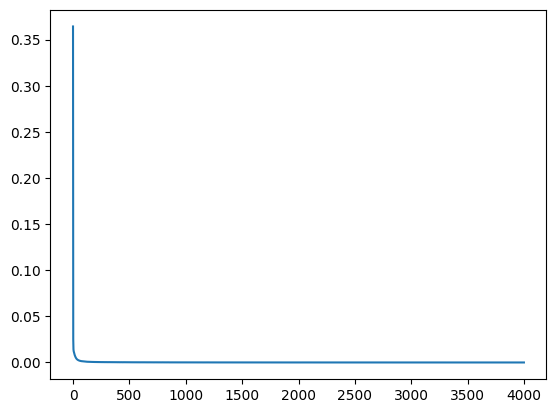

In [19]:
plt.plot(loss_arr, label="loss")
# print(loss_arr[1500])
# print(loss_arr[2400])


In [20]:
class CustomDataset2(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.I = df.iloc[x_size:, 6:7].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        # self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        # label = torch.FloatTensor(self.y[index])

        return feature

    def __len__(self):
        return self.length

In [21]:
def fx(x_esti, idx):
    # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
    return x_esti + (dataset_d2.I[idx]*100*(1.009217) / (1.600182 *3600/0.8)) #US -> 1.648484097 / DST -> 1.594214 / FUDS->1.600182  / BJDST->1.653517646
# US -> 1.007828486 / DST -> 1.00612 /  FUDS -> 1.009217  /  BJDST -> 1.001287

# @tf.function
def __d(K, n):
  return (math.factorial(K - 1 + n)) / (math.factorial(K - 1) * math.factorial(n))

# @tf.function
def PolynomialActivation(x):
  # x = x + 0.4
  N = 11
  K = 6
  zeta = 0.5 #y
  value = 0.5 #x
  dK = 0
  Sigmaz = 0
  for n in range(0, N - K):
    dK = dK + __d(K, n) * math.pow((1 - x), n)
  for n in range(0, N - K):
    Sigmaz = Sigmaz + __d(K, n) * math.pow((1 - zeta), n)
  CNK = (value * (zeta ** (-K)) - Sigmaz) / ((1 - zeta) ** (N - K))
  
  return np.where(x < 0., 0., 
                  np.where(x > 1., 1., 
                           math.pow(x, K) * (dK + (CNK * (math.pow((1 - x), (N - K)))))))
  

def SOC_fuzzy(SOC_tf, SOC_tf_prev, idx):
    # print(-1*PolynomialActivation(abs(SOC_tf - SOC_tf_prev)) + 1)
    # print(" ")
    # print(abs(SOC_tf - SOC_tf_prev))
    w1 = (-1*PolynomialActivation(abs(SOC_tf - SOC_tf_prev)) + 1)
    w2 = 1-w1

    return w1*(SOC_tf) + w2*(SOC_tf_prev)

(11026, 50, 1)
(11026, 50, 1)
torch.Size([11026])
(11095, 1)
44
(11095, 1)
torch.Size([11095])
mae :  1.0858893110174728
mse :  1.8353591951025092
rmse :  1.3547542932585632


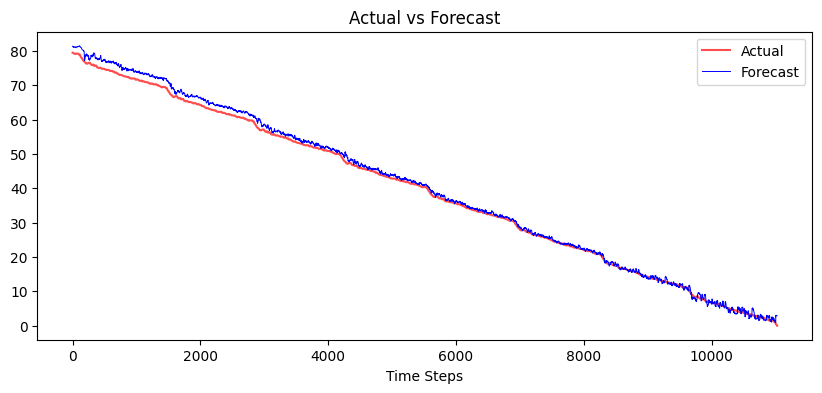

In [22]:
eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
# eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
dataset_d = CustomDataset("FUDS_80.csv", 2586)
# dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)


predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


print(predictions.shape)
print(dataset_d.y.shape)
print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

print(dataset_d.y.shape)
print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))




(11142, 50, 1)
(11142, 50, 1)
torch.Size([11142])
(11211, 1)
44
(11211, 1)
torch.Size([11211])
mae :  5.381139943894494
mse :  34.191795301982914
rmse :  5.847375077928806


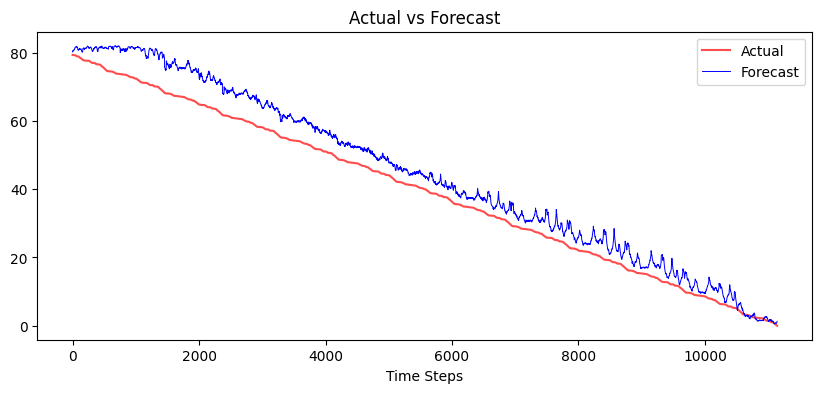

In [23]:
# eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
# dataset_d = CustomDataset("FUDS_80.csv", 2586)
dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)


predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


print(predictions.shape)
print(dataset_d.y.shape)
print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

print(dataset_d.y.shape)
print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))




In [24]:
def error_define(x, y):

    error = x-y
    return error




mae :  5.380728803965963
mse :  34.18637393985924
rmse :  5.846911487260538


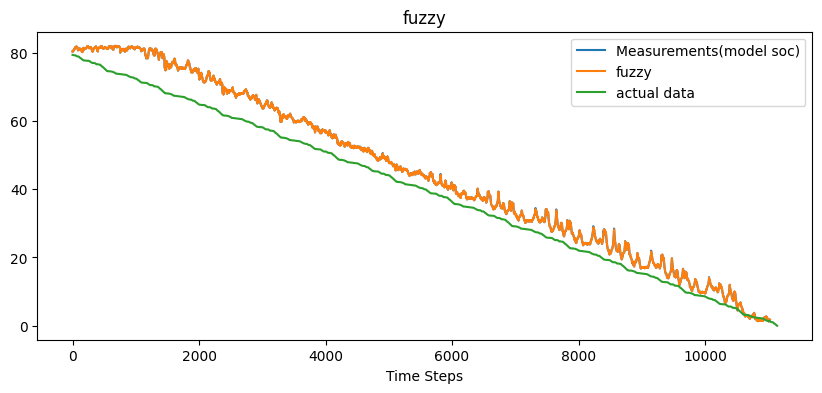

In [25]:
n_samples = 11095
# n_samples = 10639

soc_meas_save = np.zeros(n_samples)
soc_esti_save = np.zeros(n_samples)
test = np.zeros(n_samples)

dataset_d2 = CustomDataset2("FUDS_80.csv", 2586)
# dataset_d2 = CustomDataset2("DST_80.csv", 1919)

for i in range(n_samples):
    z_meas = np.array(predictions[i])
    if i<1:
        z_meas_prev = 80
    else:
        z_meas_prev = np.array(predictions[i-1])
    
    # if i == 0:
    #     x_esti = w1*z_meas + w2*80
    # else:
    #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

    x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

    soc_meas_save[i] = z_meas
    soc_esti_save[i] = x_esti
# for i in range(n_samples):
#     z_meas = np.array(predictions[i])
#     if i<1:
#         z_meas_prev = 80
#     else:
#         z_meas_prev = fx(z_meas_prev, i)
    
#     # if i == 0:
#     #     x_esti = w1*z_meas + w2*80
#     # else:
#     #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

#     x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti
#     test[i] = z_meas_prev
    
plt.figure(figsize=(10,4))

plt.plot(soc_meas_save[70:], label='Measurements(model soc)')
plt.plot(soc_esti_save[70:], label='fuzzy')
plt.plot(dataset_d.y[70:], label='actual data')
plt.legend(loc='upper right')
plt.title('fuzzy')
plt.xlabel('Time Steps')



print("mae : ", mean_absolute_error(dataset_d.y[70:10000], soc_esti_save[70:10000]))
print("mse : ", mean_squared_error(dataset_d.y[70:10000], soc_esti_save[70:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[70:10000], soc_esti_save[70:10000])))

mae :  0.6781977277483581
mse :  0.6708425650273186
rmse :  0.8190497939852733


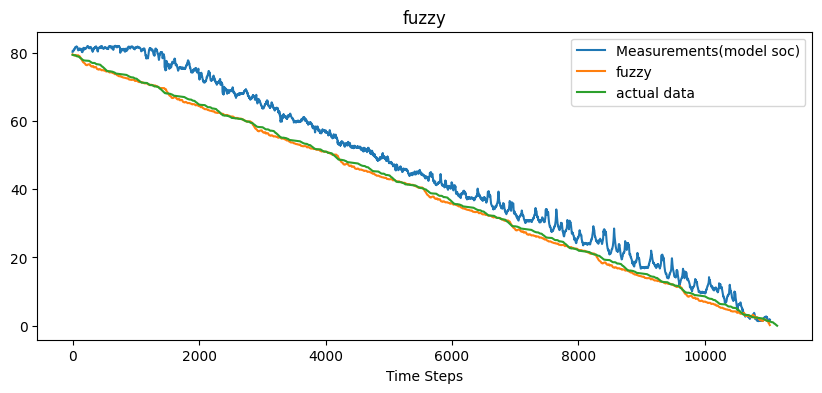

In [26]:
n_samples = 11095
# n_samples = 10639

soc_meas_save = np.zeros(n_samples)
soc_esti_save = np.zeros(n_samples)
test = np.zeros(n_samples)

dataset_d2 = CustomDataset2("FUDS_80.csv", 2586)
# dataset_d2 = CustomDataset2("DST_80.csv", 1919)


# for i in range(n_samples):
#     z_meas = np.array(predictions[i])
#     if i<1:
#         z_meas_prev = 80
#     else:
#         z_meas_prev = np.array(predictions[i-1])
    
#     # if i == 0:
#     #     x_esti = w1*z_meas + w2*80
#     # else:
#     #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

#     x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti
for i in range(n_samples):
    z_meas = np.array(predictions[i])
    if i<1:
        z_meas_prev = 80
    else:
        z_meas_prev = fx(z_meas_prev, i)
    
    # if i == 0:
    #     x_esti = w1*z_meas + w2*80
    # else:
    #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

    x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

    soc_meas_save[i] = z_meas
    soc_esti_save[i] = x_esti
    test[i] = z_meas_prev
    
plt.figure(figsize=(10,4))

plt.plot(soc_meas_save[69:], label='Measurements(model soc)')
plt.plot(soc_esti_save[69:], label='fuzzy')
plt.plot(dataset_d.y[69:], label='actual data')
plt.legend(loc='upper right')
plt.title('fuzzy')
plt.xlabel('Time Steps')



print("mae : ", mean_absolute_error(dataset_d.y[69:10000], soc_esti_save[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], soc_esti_save[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], soc_esti_save[69:10000])))


Text(0.5, 0, 'Time Steps')

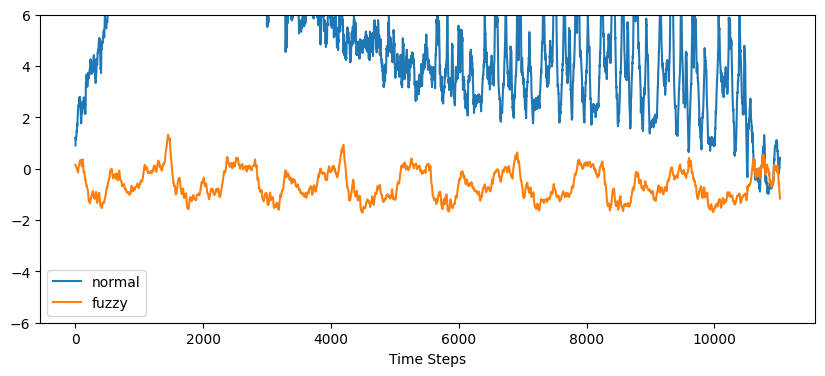

In [27]:
error_normal = np.zeros(11026)
error_fuzzy = np.zeros(11026)

for i in range(11026):
    error_nor = error_define(predictions[i+69], dataset_d.y[i+69])
    error_fuz = error_define(soc_esti_save[i+69], dataset_d.y[i+69])
    
    error_normal[i] = error_nor
    error_fuzzy[i] = error_fuz

plt.figure(figsize=(10,4))
plt.plot(error_normal)
plt.plot(error_fuzzy)
plt.ylim(-6,6)
# plt.title('Actual vs Forecast')
plt.legend(['normal', 'fuzzy'])
plt.xlabel('Time Steps')

In [28]:
def fx(x_esti, idx):
    # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
    return x_esti + (dataset_d2.I[idx]*100*(1.001287) / (1.653517646 *3600/0.8)) #US -> 1.648484097 / DST -> 1.594214 / FUDS->1.600182  / BJDST->1.653517646
# US -> 1.007828486 / DST -> 1.00612 /  FUDS -> 1.009217  /  BJDST -> 1.001287

(11142, 50, 1)
(11142, 50, 1)
torch.Size([11142])
(11211, 1)
44
(11211, 1)
torch.Size([11211])
mae :  5.381139943894494
mse :  34.191795301982914
rmse :  5.847375077928806


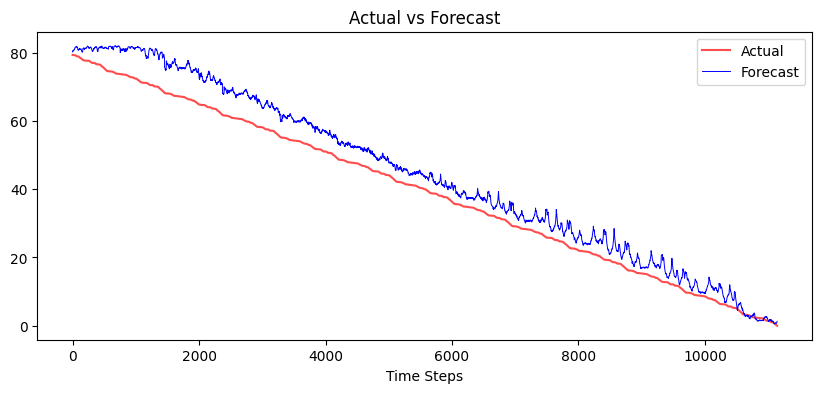

In [29]:
# eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
# dataset_d = CustomDataset("FUDS_80.csv", 2586)
dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)


predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_v, tgt_mask)
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


print(predictions.shape)
print(dataset_d.y.shape)
print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

print(dataset_d.y.shape)
print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))




In [30]:
# n_samples = 11211
# # n_samples = 10690

# soc_meas_save = np.zeros(n_samples)
# soc_esti_save = np.zeros(n_samples)
# test = np.zeros(n_samples)

# dataset_d2 = CustomDataset2("BJDST_80.csv", 1226)
# # dataset_d2 = CustomDataset2("US06_80.csv", 1207)

# for i in range(n_samples):
#     z_meas = np.array(predictions[i])
#     if i<1:
#         z_meas_prev = 80
#     else:
#         z_meas_prev = np.array(predictions[i-1])
    
#     # if i == 0:
#     #     x_esti = w1*z_meas + w2*80
#     # else:
#     #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

#     x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti
# # for i in range(n_samples):
# #     z_meas = np.array(predictions[i])
# #     if i<1:
# #         z_meas_prev = 80
# #     else:
# #         z_meas_prev = fx(z_meas_prev, i)
    
# #     # if i == 0:
# #     #     x_esti = w1*z_meas + w2*80
# #     # else:
# #     #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

# #     x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

# #     soc_meas_save[i] = z_meas
# #     soc_esti_save[i] = x_esti
# #     test[i] = z_meas_prev
    
# plt.figure(figsize=(10,4))

# plt.plot(soc_meas_save[70:], label='Measurements(model soc)')
# plt.plot(soc_esti_save[70:], label='fuzzy')
# plt.plot(dataset_d.y[70:], label='actual data')
# plt.legend(loc='upper right')
# plt.title('fuzzy')
# plt.xlabel('Time Steps')



# print("mae : ", mean_absolute_error(dataset_d.y[70:10000], soc_esti_save[70:10000]))
# print("mse : ", mean_squared_error(dataset_d.y[70:10000], soc_esti_save[70:10000]))
# print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[70:10000], soc_esti_save[70:10000])))

mae :  0.055118744859861575
mse :  0.0038820365846423902
rmse :  0.06230599156294995


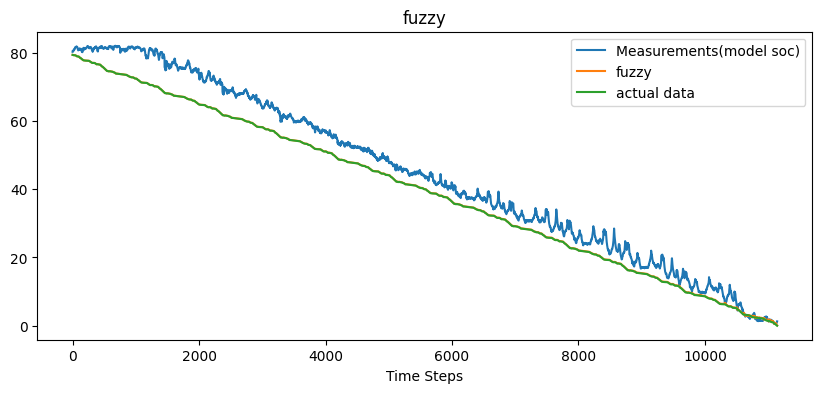

In [31]:
n_samples = 11211
# n_samples = 10690

soc_meas_save = np.zeros(n_samples)
soc_esti_save = np.zeros(n_samples)
test = np.zeros(n_samples)

dataset_d2 = CustomDataset2("BJDST_80.csv", 1226)
# dataset_d2 = CustomDataset2("US06_80.csv", 1207)

# for i in range(n_samples):
#     z_meas = np.array(predictions[i])
#     if i<1:
#         z_meas_prev = 80
#     else:
#         z_meas_prev = np.array(predictions[i-1])
    
#     # if i == 0:
#     #     x_esti = w1*z_meas + w2*80
#     # else:
#     #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

#     x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti

for i in range(n_samples):
    z_meas = np.array(predictions[i])
    if i<1:
        z_meas_prev = 80
    else:
        z_meas_prev = fx(z_meas_prev, i)
    
    # if i == 0:
    #     x_esti = w1*z_meas + w2*80
    # else:
    #     x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)

    x_esti = SOC_fuzzy(z_meas, z_meas_prev, i)

    soc_meas_save[i] = z_meas
    soc_esti_save[i] = x_esti
    test[i] = z_meas_prev
    
plt.figure(figsize=(10,4))

plt.plot(soc_meas_save[69:], label='Measurements(model soc)')
plt.plot(soc_esti_save[69:], label='fuzzy')
plt.plot(dataset_d.y[69:], label='actual data')
plt.legend(loc='upper right')
plt.title('fuzzy')
plt.xlabel('Time Steps')



print("mae : ", mean_absolute_error(dataset_d.y[69:10000], soc_esti_save[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], soc_esti_save[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], soc_esti_save[69:10000])))


Text(0.5, 0, 'Time Steps')

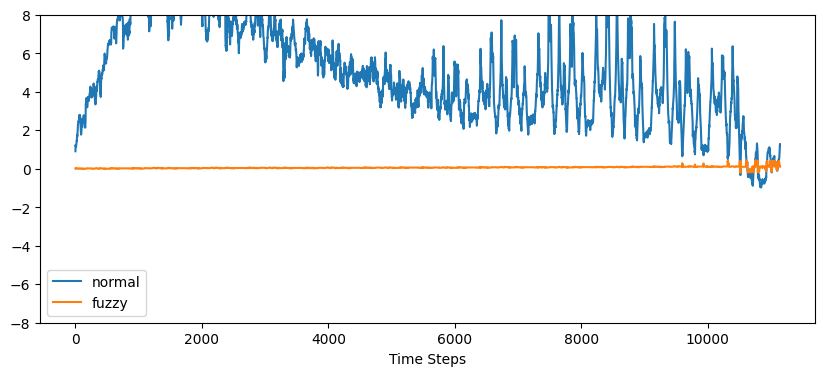

In [32]:
error_normal = np.zeros(11142)
error_fuzzy = np.zeros(11142)

for i in range(11142):
    error_nor = error_define(predictions[i+69], dataset_d.y[i+69])
    error_fuz = error_define(soc_esti_save[i+69], dataset_d.y[i+69])
    
    error_normal[i] = error_nor
    error_fuzzy[i] = error_fuz

plt.figure(figsize=(10,4))
plt.plot(error_normal)
plt.plot(error_fuzzy)
plt.ylim(-8,8)
# plt.title('Actual vs Forecast')
plt.legend(['normal', 'fuzzy'])
plt.xlabel('Time Steps')

In [33]:
n_samples = 10690

soc_meas_save = np.zeros(n_samples)
soc_esti_save = np.zeros(n_samples)

In [34]:
class CustomDataset2(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.I = df.iloc[x_size:, 6:7].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        # self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        # label = torch.FloatTensor(self.y[index])

        return feature

    def __len__(self):
        return self.length

In [35]:
# dataset_d2 = CustomDataset2("FUDS_80.csv", 2586)
dataset_d2 = CustomDataset2("BJDST_80.csv", 1226)
# dataset_d2 = CustomDataset2("DST_80.csv", 1919)
# dataset_d2 = CustomDataset2("US06_80.csv", 1207)

In [36]:
def fx(x_esti, idx):
    # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
    return x_esti + (dataset_d2.I[idx]*100*(1.007922) / (1.648484097 *3600/0.8)) #US -> 1.648484097 / DST -> 1.594214 / FUDS->1.600182  / BJDST->1.653517646

In [37]:
# x_esti, P = None, None
# for i in range(n_samples):
#     z_meas = np.array(predictions[i])
#     if i == 0:
#         x_esti, P = x_0, P_0
#     else:
#         x_esti, P = unscented_kalman_filter(z_meas, x_esti, P, i)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti

In [38]:
w1, w2 = 0.2, 0.8
for i in range(n_samples):
    z_meas = np.array(predictions[i])
    
    if i == 0:
        x_esti = w1*z_meas + w2*80
    else:
        x_esti = w1*z_meas + w2*fx(dataset_d.y[i-1],i)
        
    if i<3000:
        w1 = w1+0.0001
        w2 = w2-0.0001
        
    

    soc_meas_save[i] = z_meas
    soc_esti_save[i] = x_esti

print(w1)
print(w2)

0.49999999999996697
0.5000000000000331


In [39]:
# for i in range(n_samples):

#     if i == 0:
#         x_esti = 80
#     else:
#         x_esti = fx(dataset_d.y[i-1],i)

#     soc_esti_save[i] = x_esti

mae :  2.3893743162263865
mse :  6.563019969263305
rmse :  2.561839177088075


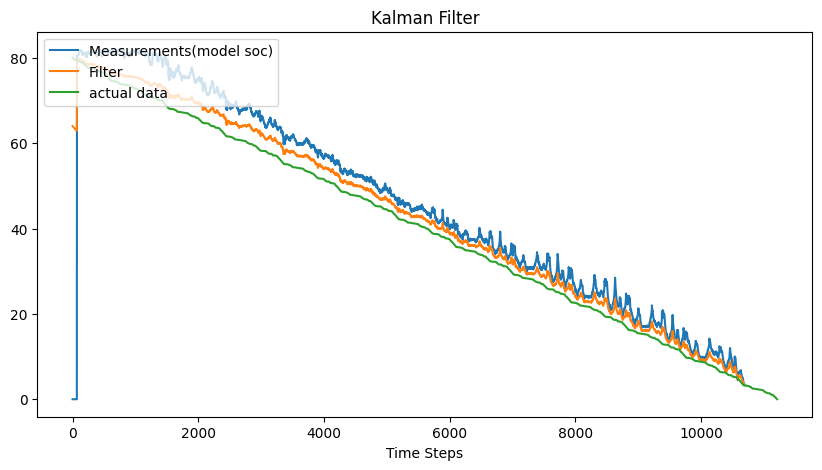

In [40]:
plt.figure(figsize=(10,5))

plt.plot(soc_meas_save, label='Measurements(model soc)')
plt.plot(soc_esti_save, label='Filter')
plt.plot(dataset_d.y, label='actual data')
plt.legend(loc='upper left')
plt.title('Kalman Filter')
plt.xlabel('Time Steps')



# plt.xlim(7500, 8500)
# plt.ylim(15, 24)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], soc_esti_save[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], soc_esti_save[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], soc_esti_save[69:10000])))

In [41]:
n = len(predictions)
k = np.arange(n)
Fs = 1/0.0001
T = n/Fs
freq = k/T
freq = freq[range(int(n/2))]

In [42]:
Y1 = np.fft.fft(predictions)/n
Y1 = Y1[range(int(n/2))]
Y2 = np.fft.fft(dataset_d.y)/n
Y2 = Y2[range(int(n/2))]

Y3 = abs(Y2)/abs(Y1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 20.0)

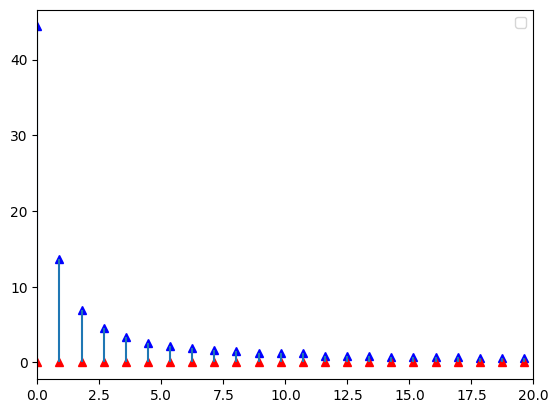

In [43]:
plt.plot(freq, abs(Y1), 'b', linestyle=' ', marker='^')
plt.plot(freq, abs(Y2), 'r', linestyle=' ', marker='^')
plt.legend()
plt.vlines(freq, [0],abs(Y1))
plt.vlines(freq, [0],abs(Y2))
plt.xlim([0, 20])
# plt.plot(abs(Y))

In [44]:
Y2

array([[0.00713545+0.j],
       [0.00713532+0.j],
       [0.00713519+0.j],
       ...,
       [0.0035945 +0.j],
       [0.00359369+0.j],
       [0.00359289+0.j]])

(0.0, 100.0)

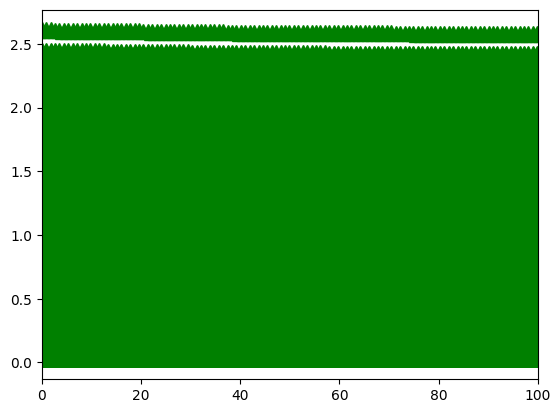

In [45]:
plt.plot(freq, abs(Y3), 'g', linestyle=' ', marker='^')
# plt.vlines(freq, [0],abs(Y3))
plt.xlim([0, 100])


In [46]:
class CustomDataset2(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.I = df.iloc[x_size:, 6:7].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        # self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        # label = torch.FloatTensor(self.y[index])

        return feature

    def __len__(self):
        return self.length

In [47]:
# A = 1

# dataset_d2 = CustomDataset2("US06_80.csv", 1207)

# dataset_d2.I

# # test = np.zeros(10690)

# # test = dataset_d2.I// 1.648484097

# # plt.plot(test)

# def fx(x_esti, idx):
#     # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
#     return x_esti + (dataset_d2.I[idx]*100*(1.007922) / (1.648484097*3600/0.8)) 



# soc_func = np.zeros(10690)

# x_esti = None
# for i in range(10690):
#     if i == 0:
#         x_esti = 80
#     else:
#         x_esti = fx(x_esti, i)
        
#     soc_func[i] = x_esti
    


In [48]:
# soc_func[10680:10690]

In [49]:
# plt.figure(figsize=(10,10))
# plt.plot(soc_func, label='Measurements(model soc)')
# plt.plot(dataset_d.y, color='red', alpha=0.7)
# plt.legend(['Actual', 'coulomb counting'])

# # # plt.xlim(0,200)
# # plt.ylim(0,100)

In [50]:
# from sklearn.metrics import mean_absolute_error 

# print(dataset_d.y.shape)
# print(predictions.shape)

# mean_absolute_error(dataset_d.y[:10000], soc_func[:10000])

칼만필터 적용 (전류적산 / 모델 예측)

In [51]:
# def kalman_filter(z_meas, x_esti, P):
#     """Kalman Filter Algorithm for One Variable."""
#     # (1) Prediction.
#     x_pred = A * x_esti
#     P_pred = A * P * A + Q

#     # (2) Kalman Gain.
#     K = P_pred * H / (H * P_pred * H + R)

#     # (3) Estimation.
#     x_esti = x_pred + K * (z_meas - H * x_pred)

#     # (4) Error Covariance.
#     P = P_pred - K * H * P_pred

#     return x_esti, P

In [52]:
# # Initialization for system model.
# A = 1
# H = 1
# Q = 0.00000005
# R = 0.00001
# # Initialization for estimation.
# x_0 = 80
# P_0 = 10

In [53]:
# n_samples = 10621

# soc_meas_save = np.zeros(n_samples)
# soc_esti_save = np.zeros(n_samples)

In [54]:
# x_esti, P = None, None
# for i in range(n_samples):
#     z_meas = predictions[i]
#     if i == 0:
#         x_esti, P = x_0, P_0
#     else:
#         x_esti, P = kalman_filter(z_meas, x_esti, P)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti

In [55]:
# plt.plot(soc_meas_save, label='Measurements(model soc)')
# plt.plot(soc_esti_save, label='Kalman Filter')
# plt.plot(dataset_d.y, label='actual data')
# plt.legend(loc='upper left')
# plt.title('Kalman Filter')
# plt.xlabel('Time Steps')

# plt.xlim(5200, 5400)
# plt.ylim(39, 41)

In [56]:
# mean_absolute_error(dataset_d.y[:10000], soc_esti_save[:10000])

확장칼만필터

In [57]:
# class CustomDataset2(Dataset):
#     def __init__(self, file_path, x_size):
#         df = pd.read_csv(file_path)
#         #print(df.isnull().sum())

#         self.I = df.iloc[x_size:, 6:7].values
#         #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
#         # self.y = df.iloc[x_size:, 13:14].values
        
#         self.length = len(df) - x_size

#     #getitem이거 왜씀?
#     def __getitem__(self, index):
#         # x = torch.FloatTensor([self.x[index]])
#         # y = torch.FloatTensor([self.y[index]])
#         # return x, y
#         feature = torch.FloatTensor([self.x[index]])
#         # label = torch.FloatTensor(self.y[index])

#         return feature

#     def __len__(self):
#         return self.length

In [58]:
# dataset_d2 = CustomDataset2("US06_80.csv", 1207)

# dataset_d2.I

In [59]:
# def Ajacob_at(x_esti):
#     return A


# def Hjacob_at(x_pred):
#     return H


# def fx(x_esti, idx):
#     # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
#     return x_esti + (dataset_d2.I[idx]*100*(1.007922) / (1.648484097*3600/0.8)) 


# def hx(x_pred):
#     return x_pred


# def extended_kalman_filter(z_meas, x_esti, P):
#     """Extended Kalman Filter Algorithm."""
#     # (1) Prediction.
#     A = Ajacob_at(x_esti)
#     x_pred = fx(x_esti)
#     P_pred = A @ P @ A.T + Q

#     # (2) Kalman Gain.
#     H = Hjacob_at(x_pred)
#     K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)

#     # (3) Estimation.
#     x_esti = x_pred + K @ (z_meas - hx(x_pred))

#     # (4) Error Covariance.
#     P = P_pred - K @ H @ P_pred

#     return x_esti, P

In [60]:
# # Initialization for system model.
# A = 1
# H = 1
# Q = 0.00000001
# R = 0.000001



# # Initialization for estimation.
# x_0 = 80
# P_0 = 10

In [61]:
# n_samples = 10621

# soc_meas_save = np.zeros(n_samples)
# soc_esti_save = np.zeros(n_samples)

In [62]:
# x_esti, P = None, None
# for i in range(n_samples):
#     z_meas = predictions[i]
#     if i == 0:
#         x_esti, P = x_0, P_0
#     else:
#         x_esti, P = kalman_filter(z_meas, x_esti, P)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti

In [63]:
# plt.plot(soc_meas_save, label='Measurements(model soc)')
# plt.plot(soc_esti_save, label='Kalman Filter')
# plt.plot(dataset_d.y, label='actual data')
# plt.legend(loc='upper left')
# plt.title('Kalman Filter')
# plt.xlabel('Time Steps')

# plt.xlim(3000, 4000)
# plt.ylim(50, 58)

In [64]:
# mean_absolute_error(dataset_d.y[:10000], soc_esti_save[:10000])

무향 칼만 필터(Unscented Kalman Filter)

In [65]:
from numpy.linalg import inv, cholesky

In [66]:
def sigma_points(mu, Sigma, kappa):
    n = 1
    Xi = np.zeros((n, 2*n+1))
    W = np.zeros(2*n+1)
    
    Xi[:, 0] = mu
    W[0] = kappa / (n + kappa)
    
    U = cholesky((n + kappa)*Sigma)
    
    for i in range(n):
        Xi[:, i+1]   = mu + U[:, i]
        Xi[:, n+i+1] = mu - U[:, i]
        W[i+1]       = 1 / (2*(n+kappa))
        W[n+i+1]     = W[i+1]
        
    return Xi, W

In [67]:
def UT(Xi, W, noiseCov):
    mean = np.sum(W * Xi, axis=1)
    cov = W * (Xi - mean.reshape(-1, 1)) @ (Xi  - mean.reshape(-1, 1)).T
    return mean, cov + noiseCov

In [68]:
# dataset_d2 = CustomDataset2("FUDS_80.csv", 2586)
dataset_d2 = CustomDataset2("BJDST_80.csv", 1226)
# dataset_d2 = CustomDataset2("DST_80.csv", 1919)

dataset_d2.I

array([[-0.11091334],
       [-0.11109395],
       [-0.83389229],
       ...,
       [-1.1113081 ],
       [-1.1113081 ],
       [-1.1114887 ]])

In [69]:
def fx(x_esti, idx):
    # return A * x_esti + (dataset_d2.I[idx]*(1/44.72) / (1.648484097)) 
    return x_esti + (dataset_d2.I[idx]*100*(1.007922) / (1.653517646 *3600/0.8)) #US -> 1.648484097 / DST -> 1.594214 / FUDS->1.600182  / BJDST->1.653517646


def hx(x_pred):
    return x_pred

In [70]:
def unscented_kalman_filter(z_meas, x_esti, P, idx):
    """Unscented Kalman Filter Algorithm."""
    # (1) Sample Sigma Points and Weights.
    Xi, W = sigma_points(x_esti, P, kappa)

    # (2) Predict Mean and Error Covariance of States.
    #fXi = fx(Xi) + (dataset_d.y[idx]-x_esti)
    fXi = fx(Xi, idx) 
    x_pred, P_x = UT(fXi, W, Q)

    # (3) Calculate Mean and Error Covariance for the Expected Observation.
    hXi = hx(fXi)
    z_pred, P_z = UT(hXi, W, R)

    # (4) Calculate Off Diagonal Elements of Error Covariance and Kalman Gain.
    Pxz = W * (fXi - x_pred.reshape(-1, 1)) @ (hXi - z_pred.reshape(-1, 1)).T
    K = Pxz @ inv(P_z)

    # (5) Estimate Mean and Error Covariance of States. 
    x_esti = x_pred + K @ (z_meas - z_pred)
    P = P_x - K @ P_z @ K.T

    return x_esti, P



In [71]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
# A = np.eye(3) + dt * np.array([[0, 1, 0],
#                                [0, 0, 0],
#                                [0, 0, 0]])
A = 1
Q = (10**(-5)) * 1
R = (10**(-1)) * 5

# Initialization for estimation.
x_0 = 80
P_0 = 10 * np.eye(1) # p_0 = 10

# Initialization for sigma points.
kappa = 2

In [72]:
n_samples = 10537

soc_meas_save = np.zeros(n_samples)
soc_esti_save = np.zeros(n_samples)

In [73]:
x_esti, P = None, None
for i in range(n_samples):
    z_meas = np.array(predictions[i])
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = unscented_kalman_filter(z_meas, x_esti, P, i)

    soc_meas_save[i] = z_meas
    soc_esti_save[i] = x_esti

Text(0.5, 0, 'Time Steps')

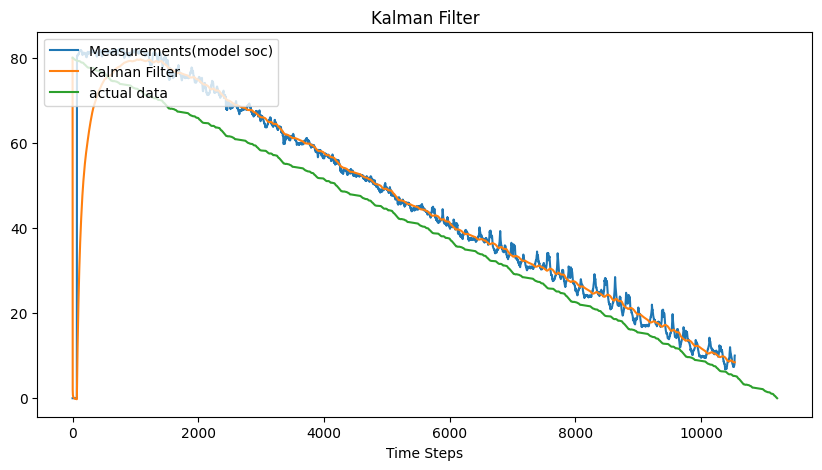

In [74]:
plt.figure(figsize=(10,5))

plt.plot(soc_meas_save, label='Measurements(model soc)')
plt.plot(soc_esti_save, label='Kalman Filter')
plt.plot(dataset_d.y, label='actual data')
plt.legend(loc='upper left')
plt.title('Kalman Filter')
plt.xlabel('Time Steps')



# plt.xlim(7500, 8500)
# plt.ylim(15, 24)

In [75]:
print("mae : ", mean_absolute_error(dataset_d.y[:10000], soc_esti_save[:10000]))
print("mse : ", mean_squared_error(dataset_d.y[:10000], soc_esti_save[:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[:10000], soc_esti_save[:10000])))

mae :  6.465228685705452
mse :  103.39514647024806
rmse :  10.16834039901537


+

In [76]:
# # Initialization for system model.
# A = 1
# H = 1
# Q = 0.00000001
# R = 0.00001



# # Initialization for estimation.
# x_0 = 80
# P_0 = 10

In [77]:
# x_esti, P = None, None
# for i in range(n_samples):
#     z_meas = soc_esti_save[i]
#     if i == 0:
#         x_esti, P = x_0, P_0
#     else:
#         x_esti, P = kalman_filter(z_meas, x_esti, P)

#     soc_meas_save[i] = z_meas
#     soc_esti_save[i] = x_esti

In [78]:
# plt.plot(soc_meas_save, label='Measurements(model soc)')
# plt.plot(soc_esti_save, label='Kalman Filter')
# plt.plot(dataset_d.y, label='actual data')
# plt.legend(loc='upper left')
# plt.title('Kalman Filter')
# plt.xlabel('Time Steps')


# plt.xlim(4000, 5000)
# plt.ylim(42, 50)

In [79]:
# mean_absolute_error(dataset_d.y[:10000], soc_esti_save[:10000])